In [1]:
 from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import glob, os,shutil

import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy import save
from numpy.random import seed
from numpy import asarray

import librosa                    
import librosa.display
import IPython.display as ipd
import scipy.io.wavfile
from scipy.fftpack import dct

import tensorflow as tf
from tensorflow.random import set_seed

import operator
import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras import applications
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.callbacks import ModelCheckpoint,CSVLogger
from keras import regularizers

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler

import pickle 
import pandas as pd
import csv

from csv import writer
from csv import DictWriter
from sklearn.model_selection import GridSearchCV
# from tensorflow.keras import layers



In [3]:
#Set seed
seed(42)
tf.random.set_seed(42)

In [4]:
N_OUTPUT_LABELS=7
lr=0.001
batch_size=8

emotions_dict={0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Neutral',
 5: 'Sad',
 6: 'Surprise'}

emotions_reversed_dict = {v: k for k, v in emotions_dict.items() }

def get_emo(prediction):
  emo=list(prediction).index(max(prediction))
  return emotions_dict[emo]

def get_emo_value(prediction):
  return list(prediction).index(max(prediction))

def get_one_hot_pred(prediction):
  one_hot_label=[0]*7
  emo=list(prediction).index(max(prediction))
  one_hot_label[emo]=1
  return one_hot_label



In [5]:
emotions_reversed_dict

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
# predictions_dict_paths=["/content/vgg_audio_model_preds_train.pkl","/content/vgg_audio_model_preds_test.pkl",
#                "/content/sfew_predictions_tr.pkl","/content/sfew_predictions_te.pkl"]


# with open(predictions_dict_paths[0], 'rb') as f:
#     audio_train_preds = pickle.load(f)

# with open(predictions_dict_paths[1], 'rb') as f:
#   audio_test_preds = pickle.load(f)

# # with open(predictions_dict_paths[2], 'rb') as f:
# #     sfew_video_train_preds = pickle.load(f) 

# # with open(predictions_dict_paths[3], 'rb') as f:
# #     sfew_video_test_preds = pickle.load(f)

# # with open("/content/train_video_labels.pkl", 'rb') as f:
# #     train_video_labels = pickle.load(f)

# # with open("/content/val_video_labels.pkl", 'rb') as f:
# #     val_video_labels = pickle.load(f)


# #new m2:


# m2_predictions_dict_paths=["/content/afew_images_SFEWpredictions__m2_te.pkl",
#                            "/content/afew_images_SFEWpredictions_m2_tr.pkl"]  # aquests noms haurien de dir sfew


# with open(m2_predictions_dict_paths[1], 'rb') as f:
#     sfew_video_train_preds_m2 = pickle.load(f) 

# with open(m2_predictions_dict_paths[0], 'rb') as f:
#     sfew_video_test_preds_m2 = pickle.load(f)

In [7]:
labels_dirs=["/content/train_video_labels.pkl","/content/val_video_labels.pkl"]

with open(labels_dirs[0], 'rb') as f:
  train_labels = pickle.load(f)

with open(labels_dirs[1], 'rb') as f:
  val_labels = pickle.load(f)

#AUDIO predictions with VGG model trained with Spectrograms converted into images
audio_preds=["/content/vgg_audio_model_preds_train.pkl","/content/vgg_audio_model_preds_test.pkl"]

with open(audio_preds[0], 'rb') as f:
  audio_train_preds = pickle.load(f)

with open(audio_preds[1], 'rb') as f:
  audio_test_preds = pickle.load(f)

#VIDEO predictions with AFEW video images predicted with VGG16 model trained with the SFEW images
# video_preds=["/content/afew_videos_imgs_predictions_m2_tr.pkl","/content/afew_videos_imgs_predictions_m2_val.pkl","/content/afew_videos_imgs_predictions_m2_te.pkl"]

video_preds=["/content/afew_videos_imgs_predictions_dict_m3_tr.pkl","/content/afew_videos_imgs_predictions_dict__bo_m3_te.pkl"]

with open(video_preds[0], 'rb') as f:
  video_train_preds = pickle.load(f)

with open(video_preds[1], 'rb') as f:
  video_test_preds = pickle.load(f)

#VIDEO with SFEW video images predicted with VGG16 model trained with the SFEW images
sfew_preds=["/content/sfew_predictions_tr.pkl","/content/sfew_predictions_te.pkl"]

with open(sfew_preds[0], 'rb') as f:
  sfew_video_train_preds = pickle.load(f)

with open(sfew_preds[1], 'rb') as f:
  sfew_video_test_preds = pickle.load(f)




In [8]:
len(video_train_preds)

756

In [ ]:
# df=pd.DataFrame(audio_train_preds)

In [9]:
print(len(audio_train_preds))
print(len(audio_test_preds))
print("_____________")

print(len(video_train_preds))
print(len(video_test_preds))

print("_____________")
print(len(sfew_video_train_preds))
print(len(sfew_video_test_preds))

773
381
_____________
756
370
_____________
378
188


In [ ]:
# for a,b in list(audio_test_preds.items()):
#   # print(item)
#   # a,b=list(item)
#   print(a)
#   # print(b)


In [ ]:
#audio_test_preds.items()

dict_items([('004041920', 'Sad'), ('010948367', 'Sad'), ('015238600', 'Sad'), ('011006040', 'Sad'), ('005711000', 'Sad'), ('010320007', 'Sad'), ('011616534', 'Sad'), ('011538834', 'Sad'), ('002239440', 'Sad'), ('010854607', 'Sad'), ('010741680', 'Sad'), ('011823760', 'Sad'), ('005307640', 'Sad'), ('011553514', 'Sad'), ('005700400', 'Sad'), ('000647360', 'Sad'), ('011131080', 'Sad'), ('012401520', 'Sad'), ('013139640', 'Sad'), ('010010080', 'Sad'), ('001013367', 'Sad'), ('013714720', 'Sad'), ('011602240', 'Sad'), ('011341440', 'Sad'), ('011543240', 'Sad'), ('015626280', 'Sad'), ('010622447', 'Sad'), ('010507927', 'Sad'), ('013609600', 'Sad'), ('005859040', 'Sad'), ('013104000', 'Sad'), ('001103160', 'Sad'), ('010552367', 'Sad'), ('002916200', 'Sad'), ('014735000', 'Sad'), ('003024767', 'Sad'), ('001444527', 'Sad'), ('014424874', 'Sad'), ('000943680', 'Sad'), ('011401160', 'Sad'), ('004039607', 'Sad'), ('010715720', 'Sad'), ('005023200', 'Sad'), ('013852920', 'Sad'), ('002259807', 'Sad')

In [11]:
#test 0 obtain accuracy and confussion matrix of each set predictions:

#Test set audio:
print("audio")
predictions,real_labels=[],[]
for audio_id in audio_test_preds.keys():
  # print(audio_test_preds[audio_id])
  # print(get_emo(audio_test_preds[audio_id][0]))
  # print(val_labels[audio_id])
  # print("---------------")
  predictions.append(get_emo(audio_test_preds[audio_id][0]))
  real_labels.append(val_labels[audio_id])
  
# print(real_labels)
# print(predictions)

# print(len(real_labels))
# print(len(predictions))

print("accuracy: ",accuracy_score(real_labels, predictions))

numeric_real_label=[emotions_reversed_dict[label] for label in real_labels]
numeric_preds=[emotions_reversed_dict[pred] for pred in predictions]

print(confusion_matrix(real_labels, predictions)[:,:])
print("f1: ",f1_score(numeric_real_label, numeric_preds,average="weighted"))

print("_______________________________________________")
print("VIDEO:")
#Test set video:

predictions,real_labels=[],[]
for id in video_test_preds.keys():
  predictions.append(get_emo(video_test_preds[id][0]))
  real_labels.append(val_labels[id])
  
print("accuracy: ",accuracy_score(real_labels, predictions))

numeric_real_label=[emotions_reversed_dict[label] for label in real_labels]
numeric_preds=[emotions_reversed_dict[pred] for pred in predictions]

print(confusion_matrix(real_labels, predictions)[:,:])
print("f1: ",f1_score(numeric_real_label, numeric_preds,average="weighted"))

print("-------------------------------------------")
print("sfew images:")

predictions,real_labels=[],[]
for id in sfew_video_test_preds.keys():
  predictions.append(get_emo(sfew_video_test_preds[id][0]))
  real_labels.append(val_labels[id])

print("accuracy: ",accuracy_score(real_labels, predictions))

numeric_real_label=[emotions_reversed_dict[label] for label in real_labels]
numeric_preds=[emotions_reversed_dict[pred] for pred in predictions]

print(confusion_matrix(real_labels, predictions)[:,:])
print("f1: ",f1_score(numeric_real_label, numeric_preds,average="weighted"))





audio
accuracy:  0.2755905511811024
[[31  3  1 22  3  4  0]
 [ 8  6  1 13  4  8  0]
 [ 8  2  9 16  4  4  3]
 [10  6  6 26  5  9  1]
 [10  4  2 26 15  4  0]
 [ 7  5  8 16  7 13  5]
 [ 6  1  4 18  7  5  5]]
f1:  0.26632279319823626
_______________________________________________
VIDEO:
accuracy:  0.22702702702702704
[[43  0  0  1  5 10  0]
 [18  0  0  2  2 17  0]
 [32  0  0  1  1 10  0]
 [22  0  0  9  5 25  2]
 [20  0  0  0  6 33  1]
 [24  0  0  1  7 26  1]
 [27  0  0  0  1 18  0]]
f1:  0.1600224010076227
-------------------------------------------
sfew images:
accuracy:  0.39361702127659576
[[25  0  0  7  2  0  1]
 [ 5  0  0  9  5  2  1]
 [ 9  1  0  5  2  2  4]
 [ 3  0  0 25  4  2  1]
 [ 4  0  0  1 12  1  4]
 [ 7  0  0  2  8  8  3]
 [ 8  0  0  5  6  0  4]]
f1:  0.3268842300484621


In [ ]:
#Test set imagenes sfew videos:

predictions,real_labels=[],[]
for id in sfew_video_test_preds.keys():
  # print(audio_test_preds[audio_id])
  predictions.append(get_emo(sfew_video_test_preds[id][0]))
  real_labels.append(val_video_labels[id])

# print("f1: ",f1_score(real_labels, predictions),average='weighted')
print("accuracy: ",accuracy_score(real_labels, predictions))
print(confusion_matrix(real_labels, predictions)[:,:])

accuracy:  0.39361702127659576
[[25  0  0  7  2  0  1]
 [ 5  0  0  9  5  2  1]
 [ 9  1  0  5  2  2  4]
 [ 3  0  0 25  4  2  1]
 [ 4  0  0  1 12  1  4]
 [ 7  0  0  2  8  8  3]
 [ 8  0  0  5  6  0  4]]


In [32]:
# video_keys=list(video_train_preds.keys())
# print(len(video_keys))

# audio_keys=list(audio_train_preds.keys())
# print(len(audio_keys))

# print(audio_keys)
# print(video_keys)

# video_keys.extend(audio_keys)

# video_keys.extend(audio_keys)
# # print(len(video_keys))

# common_keys=set(video_keys)
# print(len(common_keys))


In [31]:
#Extract train features:

feature_vectors,feature_labels=[],[]

for id in list(video_train_preds.keys()):
  feature=np.append(video_train_preds[id][0], audio_train_preds[id][0] )
  feature_vectors.append(feature)
  feature_labels.append(emotions_reversed_dict[train_labels[id]])

x_train=feature_vectors
y_train=tf.keras.utils.to_categorical(feature_labels)

#Extract val features:
feature_vectors,feature_labels=[],[]

for id in list(video_test_preds.keys()):
  feature=np.append(video_test_preds[id][0], audio_test_preds[id][0] )
  feature_vectors.append(feature)
  feature_labels.append(emotions_reversed_dict[val_labels[id]])

x_val=feature_vectors
y_val=tf.keras.utils.to_categorical(feature_labels)

In [ ]:
#Extract train features:

feature_vectors,feature_labels=[],[]

for id in sfew_video_train_preds.keys():
  feature=np.append( sfew_video_train_preds[id][0], audio_train_preds[id][0] )
  feature_vectors.append(feature)
  feature_labels.append(emotions_reversed_dict[train_video_labels[id]])

x_train=feature_vectors
y_train=tf.keras.utils.to_categorical(feature_labels)

#Extract val features:

feature_vectors,feature_labels=[],[]

for id in sfew_video_test_preds.keys():
  feature=np.append( sfew_video_test_preds[id][0], audio_test_preds[id][0] )
  feature_vectors.append(feature)
  feature_labels.append(emotions_reversed_dict[val_video_labels[id]])

x_val=feature_vectors
y_val=tf.keras.utils.to_categorical(feature_labels)

In [ ]:
# feature_labels
(39+27)/2 

33.0

In [50]:
# TEST 0 promig audio i video:
audio_preds_sum,video_preds_sum=[],[]
predictions,real_labels,feature_keys=[],[],[]

feature_vectors_dict={}

for id in video_test_preds.keys():

  #test de que esten normalizados
  audio_preds_sum.append(np.sum(audio_test_preds[id]))
  video_preds_sum.append(np.sum(video_test_preds[id][0]))

  #crear vectores de features
  feature=np.append(video_test_preds[id][0], audio_test_preds[id][0] )
  # print(feature)
  feature_vectors_dict[id]=feature
  feature_keys.append(emotions_reversed_dict[val_labels[id]])

  #media de las predicciones
  avgd_pred=(video_test_preds[id]+audio_test_preds[id][0])/2
  predictions.append(get_emo(avgd_pred[0]))
  real_labels.append(val_labels[id])
  
print("f1: ",f1_score(real_labels, predictions,average="weighted"))
print("accuracy: ",accuracy_score(real_labels, predictions))
print(confusion_matrix(real_labels, predictions)[:,:])

print(set(audio_preds_sum))
print(set(video_preds_sum))

##REVISAR xq las probabilidades del video suman más de 1 !!

f1:  0.2549847965399458
accuracy:  0.2945945945945946
[[41  0  0  4  4 10  0]
 [10  2  0 10  4 13  0]
 [19  0  4  4  5 10  2]
 [20  3  2 17  5 16  0]
 [14  2  1  6 18 19  0]
 [15  1  2  4  8 25  4]
 [18  1  1  6  5 13  2]]
{0.99999994, 1.0000001, 0.9999998, 1.0, 0.9999999, 0.99999976}
{0.9999999925494194, 1.0000000059118737, 1.0000000047056297, 1.0000000100943351, 1.0000000023528148, 1.000000003700782, 0.999999998966814, 1.000000011685188, 0.9999999977299012, 1.0000000027939677, 1.0, 1.0000000054569682, 0.9999999987485353, 1.0000000146683306, 1.000000003259629, 1.0000000020081643, 0.9999999927855293, 1.0000000087311491, 0.9999999948777258, 1.0000000009313226, 1.000000003958121, 1.0000000095460564, 1.0000000030267984, 1.0000000000291038, 0.9999999962747097, 0.999999986612238, 1.0000000022046152, 0.9999999914356549, 0.9999999932267449, 0.99999999905262, 1.0000000005954357, 1.000000004686336, 0.9999999997248366, 1.0000000006292722, 1.0000000013564916, 0.9999999999009129, 1.000000005712111

In [ ]:
# # TEST 0 promig audio i video:
# audio_preds_sum,video_preds_sum=[],[]
# predictions,real_labels,feature_keys=[],[],[]

# feature_vectors_dict={}

# for id in sfew_video_test_preds.keys():

#   #test de que esten normalizados
#   audio_preds_sum.append(np.sum(audio_test_preds[audio_id]))
#   video_preds_sum.append(np.sum(sfew_video_test_preds[audio_id][0]))

#   #crear vectores de features
#   feature=np.append( sfew_video_test_preds[audio_id][0], audio_test_preds[audio_id][0] )
#   # print(feature)
#   feature_vectors_dict[id]=feature
#   feature_keys.append(emotions_reversed_dict[val_video_labels[id]])

#   #media de las predicciones
#   avgd_pred=(sfew_video_test_preds[id]+audio_test_preds[audio_id][0])/2
#   predictions.append(get_emo(avgd_pred[0]))
#   real_labels.append(val_video_labels[id])
  
# print("f1: ",f1_score(real_labels, predictions))
# print("accuracy: ",accuracy_score(real_labels, predictions))
# print(confusion_matrix(real_labels, predictions)[:,:])

# print(set(audio_preds_sum))
# print(set(video_preds_sum))

# ##REVISAR xq las probabilidades del video suman más de 1 !!

accuracy:  0.3404255319148936
[[20  0  0  4 11  0  0]
 [ 5  0  0  4 12  1  0]
 [ 6  0  0  4 12  1  0]
 [ 1  0  0 21 13  0  0]
 [ 2  0  0  1 19  0  0]
 [ 4  0  0  2 19  3  0]
 [ 3  0  0  2 17  0  1]]
{1.0}
{1.0000000163563527}


In [ ]:
print(len(x_val))
print(len(x_train))
print(len(y_val))
print(len(y_train))

188
378
188
378


In [33]:
print(asarray(x_train).shape)
print(asarray(x_val).shape)
print(asarray(y_train).shape)
print(asarray(y_val).shape)

x_train=asarray(x_train)
x_val=asarray(x_val)
y_train=asarray(y_train)
y_val=asarray(y_val)

(756, 14)
(370, 14)
(756, 7)
(370, 7)


In [ ]:
Xtrain, Xval, Ytrain, Yval = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [34]:
#Model 1
model = Sequential()
model.add(Dense(units=28,input_dim=14,activation='relu'))
model.add(Dropout(0.25))
# model.add(BatchNormalization())
model.add(Dense(units=N_OUTPUT_LABELS,
                activation='softmax'))
model.summary()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 28)                420       
_________________________________________________________________
dropout (Dropout)            (None, 28)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 203       
Total params: 623
Trainable params: 623
Non-trainable params: 0
_________________________________________________________________


In [35]:
lr=0.001
batch_size=8
epochs=50
history=model.fit(x_train, y_train,
                  epochs=epochs,
                  validation_data=(x_val, y_val),
                  batch_size=batch_size)


Epoch 1/50
95/95 [==============================] - 15s 8ms/step - loss: 1.9374 - categorical_accuracy: 0.1635 - accuracy: 0.1635 - val_loss: 1.9152 - val_categorical_accuracy: 0.2243 - val_accuracy: 0.2243
Epoch 2/50
95/95 [==============================] - 0s 4ms/step - loss: 1.7844 - categorical_accuracy: 0.4275 - accuracy: 0.4275 - val_loss: 1.8883 - val_categorical_accuracy: 0.2351 - val_accuracy: 0.2351
Epoch 3/50
95/95 [==============================] - 0s 3ms/step - loss: 1.6681 - categorical_accuracy: 0.4648 - accuracy: 0.4648 - val_loss: 1.8711 - val_categorical_accuracy: 0.2514 - val_accuracy: 0.2514
Epoch 4/50
95/95 [==============================] - 0s 4ms/step - loss: 1.5286 - categorical_accuracy: 0.5539 - accuracy: 0.5539 - val_loss: 1.8627 - val_categorical_accuracy: 0.2595 - val_accuracy: 0.2595
Epoch 5/50
95/95 [==============================] - 0s 3ms/step - loss: 1.4298 - categorical_accuracy: 0.5951 - accuracy: 0.5951 - val_loss: 1.8637 - val_categorical_accuracy:

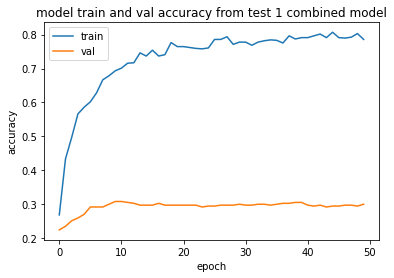

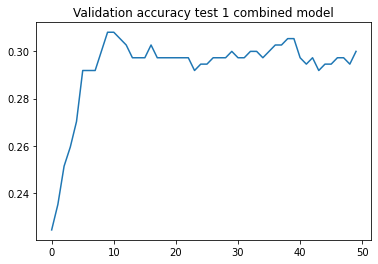

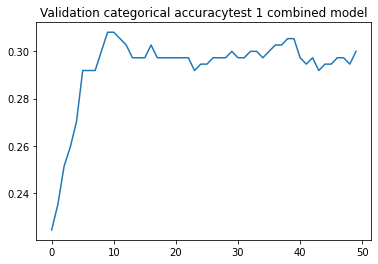

In [36]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy from "+title)
  # plt.savefig("Combinedmodel1.png")
  # plt.show()
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.figure()
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title("Validation categorical accuracy"+title)

plot_model(history,"test 1 combined model")

In [ ]:
#Test amb conjunt de test extret del de train 
lr=0.001
batch_size=8
epochs=50

history=model.fit(Xtrain, Ytrain,
                   epochs=epochs,
                   validation_data=(Xval, Yval),
                   batch_size=batch_size)

Epoch 1/50
36/36 [==============================] - 1s 11ms/step - loss: 1.8869 - categorical_accuracy: 0.2916 - accuracy: 0.2916 - val_loss: 1.8005 - val_categorical_accuracy: 0.5158 - val_accuracy: 0.5158
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 1.8022 - categorical_accuracy: 0.4449 - accuracy: 0.4449 - val_loss: 1.7160 - val_categorical_accuracy: 0.5789 - val_accuracy: 0.5789
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 1.7290 - categorical_accuracy: 0.4706 - accuracy: 0.4706 - val_loss: 1.6332 - val_categorical_accuracy: 0.6000 - val_accuracy: 0.6000
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 1.6749 - categorical_accuracy: 0.5006 - accuracy: 0.5006 - val_loss: 1.5484 - val_categorical_accuracy: 0.6316 - val_accuracy: 0.6316
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 1.5804 - categorical_accuracy: 0.5410 - accuracy: 0.5410 - val_loss: 1.4700 - val_categorical_accuracy:

In [37]:
predictions=model.predict(x_val)
one_hot_preds= [get_one_hot_pred(pred) for pred in predictions]
emo_preds=[get_emo_value(pred) for pred in predictions]
emo_val=[ get_emo_value(pred) for pred in y_val]

# one_hot_preds

In [39]:
print("accuracy: ",accuracy_score(y_val, one_hot_preds))
print(confusion_matrix(emo_val, emo_preds))
print("f1: ",f1_score(real_labels, predictions),average='weighted')

accuracy:  0.3
[[25  9  1 10  3  7  4]
 [ 7 10  1 10  3  8  0]
 [ 8  6  9  6  5  3  7]
 [ 7 11  6 22  5 10  2]
 [ 8  6  2 12 22  7  3]
 [ 6  7  8  7 10 16  5]
 [ 5  4  4 13  5  8  7]]


In [ ]:
predictions.shape

(188, 7)

In [ ]:
model.save("CombinedModel1.h5")

In [42]:
print("accuracy: ",accuracy_score(y_val, one_hot_preds))
print(confusion_matrix(emo_val, emo_preds))
print("f1: ",f1_score(emo_val, emo_preds,average='weighted'))

accuracy:  0.3
[[25  9  1 10  3  7  4]
 [ 7 10  1 10  3  8  0]
 [ 8  6  9  6  5  3  7]
 [ 7 11  6 22  5 10  2]
 [ 8  6  2 12 22  7  3]
 [ 6  7  8  7 10 16  5]
 [ 5  4  4 13  5  8  7]]
f1:  0.2975362454467308


In [ ]:
params={}
params["num_prueba"]="P1 combinacion audio video"
params["model_name"]="CombinedModel1.h5"
params["description"]="Combinacion del modelo de video del sfew con las imagenes del sfew ordenados por video segun etiquetas del afew"
params["model description"]="Modelo vgg entrenado imagenes y vgg imagenes specs audio combinado con capa densa 28 neuronas relu y dropout capa final 7 neuronas softmax "
params["DROPOUT"]=0.25
params["learning rate"]=lr
params["N_OUTPUT_LABELS"]=N_OUTPUT_LABELS
params["batch_size"]=batch_size
params["epochs"]=epochs


with open("/content/results_comb_model.csv", 'a') as f: 
  dictwriter_object = DictWriter(f, fieldnames=params.keys()) 
  dictwriter_object .writeheader()
  dictwriter_object.writerow(params) 
  f.close()

In [45]:
# SVM test:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_val)
y_true_tr=[ get_emo_value(pred) for pred in y_train]
y_true_te=[ get_emo_value(pred) for pred in y_val]

rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train_scaled, y_true_tr)
rbf_pred = rbf.predict(X_test_scaled)

print("accuracy: ",accuracy_score(y_true_te, rbf_pred))
print(confusion_matrix(y_true_te, rbf_pred))
print("f1: ",f1_score(y_true_te, rbf_pred,average='weighted'))

accuracy:  0.1837837837837838
[[ 5  0  0 54  0  0  0]
 [ 1  0  0 37  1  0  0]
 [ 2  0  0 42  0  0  0]
 [ 2  0  0 60  1  0  0]
 [ 1  0  0 56  3  0  0]
 [ 0  0  0 57  2  0  0]
 [ 0  0  0 45  1  0  0]]
f1:  0.08644205038066932


In [46]:
# Performing CV to tune parameters for best SVM fit 

from sklearn.svm import SVC
C_range = [1, 10, 100]
gamma_range = [ 1e-1,1,1e2]

params_grid = [{'kernel': ['rbf'], 'gamma': gamma_range,
                     'C': C_range},{'kernel': ['poly'],'degree':[7], 'C': C_range}]


# 
svm_model = GridSearchCV(SVC(), params_grid)
svm_model.fit(X_train_scaled, y_true_tr)

print("The best parameters are %s with a score of %0.2f"
      % (svm_model.best_params_, svm_model.best_score_))

The best parameters are {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} with a score of 0.79


In [ ]:
svm_model.cv_results_

<function sklearn.metrics._scorer._passthrough_scorer>

In [47]:

rbf = svm.SVC(kernel='rbf', gamma=0.1, C=1).fit(X_train_scaled, y_true_tr)
rbf_pred = rbf.predict(X_test_scaled)

print("accuracy: ",accuracy_score(y_true_te, rbf_pred))
print(confusion_matrix(y_true_te, rbf_pred))

f1_score(y_true_te, rbf_pred, average='weighted')

accuracy:  0.2972972972972973
[[23  7  2 10  4  8  5]
 [ 7  8  1 11  4  7  1]
 [10  9  7  5  5  2  6]
 [ 6 11  5 24  6  9  2]
 [ 8  6  2 11 24  6  3]
 [ 7  6  7  7 11 15  6]
 [ 5  3  4 12  6  7  9]]


0.2937966110459697

In [51]:
# SVM test:

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(x_train)
# X_test_scaled = scaler.transform(x_val)


# rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
# # poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

# poly_pred = poly.predict(X_test)
# rbf_pred = rbf.predict(X_test)

# poly_accuracy = accuracy_score(y_test, poly_pred)
# poly_f1 = f1_score(y_test, poly_pred, average='weighted')
# print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
# print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
